In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-08-19T13:50:15.683934+03:00

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.15.0-46-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [3]:
import time
notebookstart= time.time()

In [4]:
import os
import pickle as pkl
from typing import Optional, List

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn import preprocessing
from catboost import CatBoostRegressor, Pool, cv


import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import shap
shap.initjs()

In [6]:
from catboost import __version__ as cb_version
print(f'cb_version: {cb_version}')

cb_version: 1.0.6
sklearn_version: 1.1.1


In [7]:
%watermark --iversions

sklearn   : 1.1.1
pandas    : 1.4.3
numpy     : 1.21.5
seaborn   : 0.11.2
matplotlib: 3.5.1
shap      : 0.40.0



## Блок для воспроизводимости решений

In [8]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED  = 309487
XGB_RANDOMSEED = 56
LGB_RANDOMSEED = 874256

In [ ]:
Параметры

In [9]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [10]:
# № загрузки и название файла сабмита
NTRY = 32
NAME = f'{NTRY}_cb_pca64_sber_bord_nose_iter_2mod'

In [11]:
# константы для специальных статей по украине
VIEWS_UKR = 2554204
DEPTH_UKR = 1.799
FPR_UKR = 4.978

## Загружаем данные

In [12]:
df_train = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'), index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'), index_col= 0)

with open(os.path.join(DIR_DATA, 'clmns.pkl'), 'rb') as pickle_file:
    clmns = pkl.load(pickle_file)

In [13]:
df_train.shape, df_test.shape, 

((6981, 570), (3000, 568))

Формируем списки числовых и категориальных переменных.   
Полностью категориальные и полностью числовых формируются автоматически.   

In [14]:
cat_cols = []
num_cols = []

for el in clmns.keys():
    cat_cols.extend(clmns[el]['cat'])
    num_cols.extend(clmns[el]['num'])
    if len(clmns[el]['both']) != 0:
        print(clmns[el]['both'])

['ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr', 'interview']
['hour', 'dow', 'day', 'mounth', 'hour_peak', 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr']


Остается распределить признаки, которые могу быть как категориальными, так и числовыми.    
Сделаем это.

In [15]:
num_cols.extend(['hour', 'mounth'])
cat_cols.extend(['dow', 
                 'ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr',
                 'holiday', 'day_before_holiday', 'day_after_holiday', #'distrib_brdr',
                 #'spec_event_1',
                ])

In [16]:
for el in cat_cols:
    df_train[el] = df_train[el].astype(str)
    df_test[el] = df_test[el].astype(str)

Создаем Catboost Pools для обучения с условием разделения на start (данные до 2022-04-08) / end (данные после 2022-04-08)

In [17]:
#views
train_views_start = Pool(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                         df_train[df_train.distrib_brdr == 1][['views']],
                         cat_features = cat_cols,
                        )
train_views_end = Pool(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                       df_train[df_train.distrib_brdr == 0][['views']],
                       cat_features = cat_cols,
                      )
#depth
train_depth_start = Pool(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                         df_train[df_train.distrib_brdr == 1][['depth']],
                         cat_features = cat_cols,
                        )
train_depth_end = Pool(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                       df_train[df_train.distrib_brdr == 0][['depth']],
                       cat_features = cat_cols,
                      )

#frp
train_frp_start = Pool(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                       df_train[df_train.distrib_brdr == 1][['full_reads_percent']],
                       cat_features = cat_cols,
                      )
train_frp_end = Pool(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                     df_train[df_train.distrib_brdr == 0][['full_reads_percent']],
                     cat_features = cat_cols,

                    )

Функции для отображения важности признаков

In [18]:
def plot_feature_importance2(inp_model: CatBoostRegressor, inp_pool: Pool, imp_number: Optional[int] = 30) -> None:
    """ Отображение важности признаков (по убыванию) модели на основе величины влияния на предсказанное значение
    
    args:
        inp_model:  обученная модель CatBoostRegressor
        inp_pool:   catboost pool на котором обучалась модель
        imp_number: (опционально, 30) количество признаков для отображения
        
    return:
        None
    """
    
    
    data = pd.DataFrame({'feature_importance': inp_model.get_feature_importance(inp_pool), 
              'feature_names': inp_pool.get_feature_names()}).sort_values(by=['feature_importance'], 
                                                       ascending=True)
    
    data.nlargest(imp_number, columns="feature_importance").plot(kind='barh', figsize = (30,16)) ## plot top 40 features

In [19]:
def plot_feature_importance(importance: np.ndarray, names: List[str], model_type: str, imp_number: Optional[int] = 30) -> None:
    """Графическое отображение важности признаков (по убыванияю) модели на основе величины влияния на предсказанные значения
    
    args:
        importance: массив важности признаков (получаемый из модели CatBoostRegressor)
        names:      список имен признаков
        model_type: имя модели
        imp_number: (опционально, 30) количество признаков для отображения
        
    return:
        None
    """
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names,'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
    
    #Define size of bar plot
    plt.figure(figsize = (10,8))
    #Plot Searborn bar chart
    sns.barplot(x = fi_df['feature_importance'][:imp_number], y = fi_df['feature_names'][:imp_number])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [20]:
def plot_feature_importance_shap(inp_model: CatBoostRegressor, inp_x: pd.DataFrame) -> None:
    """ Отображение интерпритации работы модели по SHAP
    
    args:
        inp_model: обученная модель CatBoostRegressor
        inp_x:     DataFrame, на котором обучалась модель
        
    return:
        None
    """
    
    
    explainer = shap.TreeExplainer(inp_model)
    shap_values = explainer.shap_values(inp_x)
    
    shap.summary_plot(shap_values, inp_x)

## views

Обучаем модели для views с разделением на модели start (данные до 2022-04-08) / end (данные после 2022-04-08) 

In [21]:
cb_params_views = {"iterations": 2500,
                  #"depth": 2,
                  "loss_function": "RMSE",
                  'eval_metric': 'R2',
                  "verbose": False
                  }

Рассчитываем на cv оптимальное количество итераций по средней R2 на валидационных фолдах 

In [22]:
def get_model(inp_pool: Pool, inp_params: dict) -> CatBoostRegressor:
    """Обучение модели с автоматическим определением оптимального количества итераций
    на основе CV на 5 фолдов. Оптимальное количество итераций выбирается по максимальному
    среднему R2 на валидационных фолдах.
    
    args:
        inp_pool: catboost pool для обучения модели
        inp_params: параметры для обучения модели
        
    return:
        обученная модель CatBoostRegressor 
    """
    
    scores = cv(inp_pool,
                      inp_params,
                      fold_count = 5,
                      seed = CB_RANDOMSEED, 
                      plot="True"
                     )
    
    # проверка что лучшие итерации по test-RMSE-mean и test-R2-mean одинаковы
    # для cb чаще правда, для lgb и xgb чаще ложь
    #if scores['test-RMSE-mean'].argmin() != scores['test-R2-mean'].argmax():
    #    raise ValueError('wtf?', scores['test-RMSE-mean'].argmin(), scores['test-R2-mean'].argmax())
    
    print(scores[scores['test-R2-mean'] == scores['test-R2-mean'].max()].to_string())
    
    # из cv берем лучшее по test-R2-mean количество итераций
    # на нем и обучаем моедль на всех данных
    niters = scores['test-R2-mean'].argmax()
    print(niters)
    
    cb_model = CatBoostRegressor(iterations = niters,
                                 #learning_rate=0.05,
                                 #depth=10,
                                 random_seed = CB_RANDOMSEED,
                                 #n_estimators=100,
                                )
    # Fit model
    cb_model.fit(inp_pool,
                 #plot = True,
                 verbose = 100,
                )
    
    return cb_model

In [23]:
cb_params_views['iterations'] = 2500

In [24]:
%%time
model_views_start = get_model(train_views_start, cb_params_views)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5777669139
bestIteration = 1207

Training on fold [1/5]

bestTest = 0.4764881931
bestIteration = 993

Training on fold [2/5]

bestTest = 0.5332030817
bestIteration = 2455

Training on fold [3/5]

bestTest = 0.3426442651
bestIteration = 2429

Training on fold [4/5]

bestTest = 0.5917236107
bestIteration = 1587

      iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
2457        2457      0.503635     0.101053       0.997052      0.000497    58113.144369   22997.329158      4513.400049      274.380411
2457
Learning rate set to 0.023663
0:	learn: 83306.1593644	total: 56ms	remaining: 2m 17s
100:	learn: 54706.2384455	total: 2.73s	remaining: 1m 3s
200:	learn: 45316.7818176	total: 5.42s	remaining: 1m
300:	learn: 39768.8632506	total: 8.11s	remaining: 58.1s
400:	learn: 35492.0090013	total: 10.8s	remaining: 55.6s
500:	learn: 31642.7625035	total: 13.5s	remaining: 52.8s
600:	learn:

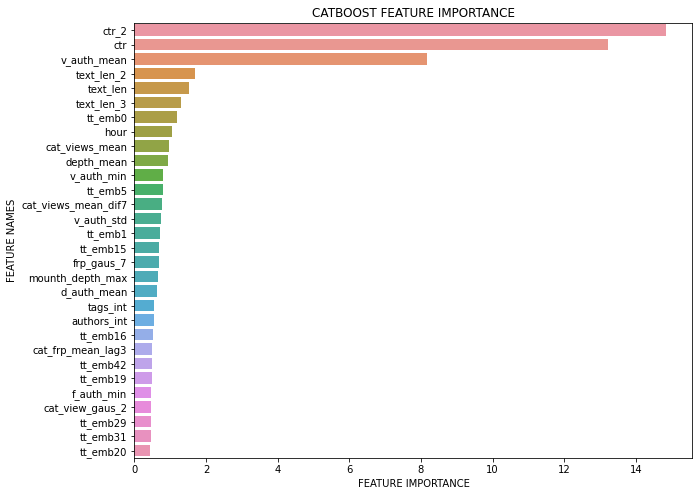

In [25]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(model_views_start.get_feature_importance(), train_views_start.get_feature_names(), 'CATBOOST')

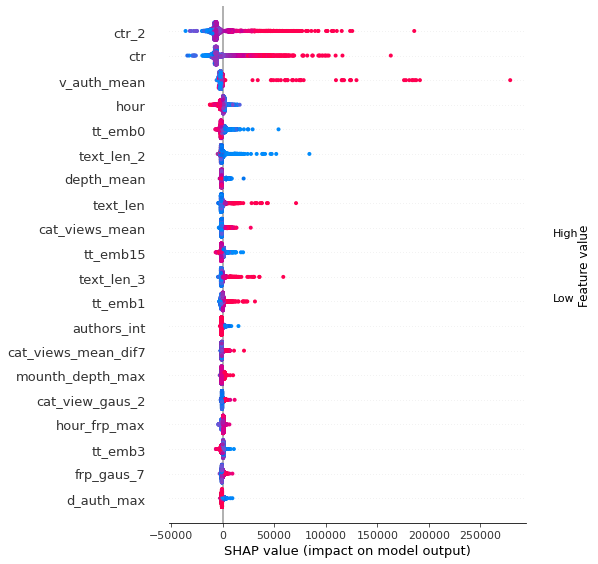

In [26]:
plot_feature_importance_shap(model_views_start, df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])

In [27]:
cb_params_views['iterations'] = 750

In [64]:
%%time
model_views_end = get_model(train_views_end, cb_params_views)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5864553304
bestIteration = 991

Training on fold [1/5]

bestTest = 0.6220321231
bestIteration = 996

Training on fold [2/5]

bestTest = 0.4818411116
bestIteration = 447

Training on fold [3/5]

bestTest = 0.6022796447
bestIteration = 539

Training on fold [4/5]

bestTest = 0.567975698
bestIteration = 999

     iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
994         994      0.571011     0.055405       0.938476      0.006281     9637.878718     982.903242      3680.697994      157.325362
994
Learning rate set to 0.050816
0:	learn: 14577.0519251	total: 28.9ms	remaining: 28.7s
100:	learn: 8024.1754648	total: 3.78s	remaining: 33.4s
200:	learn: 6619.2386055	total: 9.14s	remaining: 36.1s
300:	learn: 5699.9204785	total: 14.9s	remaining: 34.3s
400:	learn: 4995.7399147	total: 18.2s	remaining: 26.9s
500:	learn: 4497.3675295	total: 21.2s	remaining: 20.9s
600:	learn: 4040.123

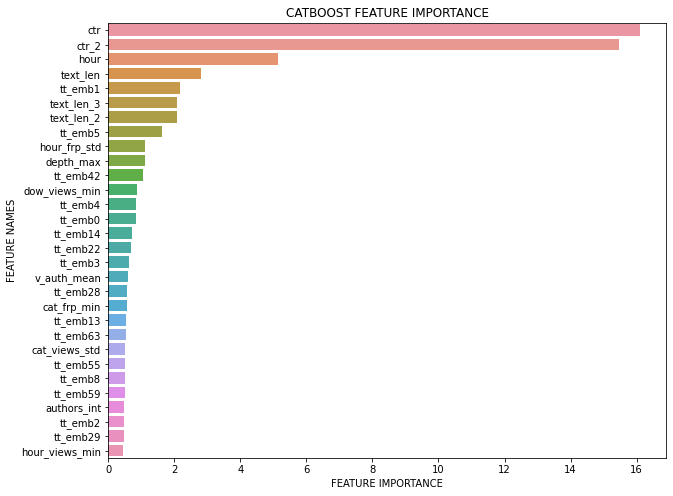

In [29]:
plot_feature_importance(model_views_end.get_feature_importance(), train_views_end.get_feature_names(), 'CATBOOST')

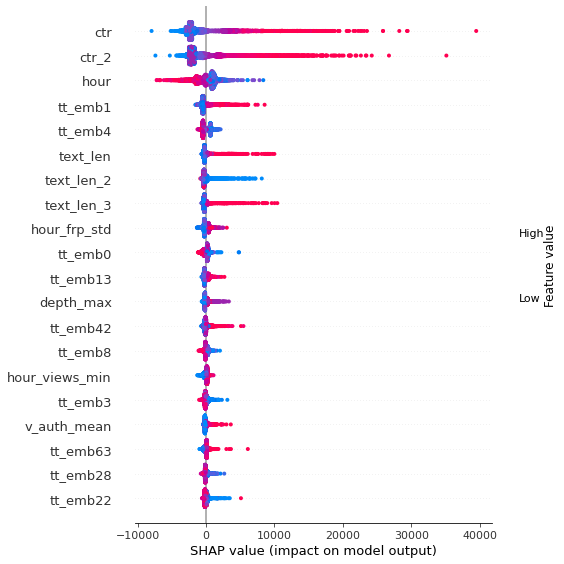

In [30]:
plot_feature_importance_shap(model_views_end, df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])

## depth

Обучаем модели для depth с разделением на модели start (данные до 2022-04-08) / end (данные после 2022-04-08) 

In [31]:
cb_params_depth = cb_params_views

In [32]:
cb_params_depth['iterations'] = 1600

In [33]:
%%time
model_depth_start = get_model(train_depth_start, cb_params_depth)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4645609909
bestIteration = 1581

Training on fold [1/5]

bestTest = 0.4442388536
bestIteration = 1495

Training on fold [2/5]

bestTest = 0.3036365029
bestIteration = 1586

Training on fold [3/5]

bestTest = 0.5694094787
bestIteration = 1577

Training on fold [4/5]

bestTest = 0.6444597381
bestIteration = 1596

      iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
1599        1599      0.485088     0.129972       0.972494      0.002921        0.036515       0.001641         0.008651        0.000109
1599
Learning rate set to 0.033554
0:	learn: 0.0516220	total: 26.8ms	remaining: 42.9s
100:	learn: 0.0333642	total: 2.85s	remaining: 42.3s
200:	learn: 0.0301284	total: 5.97s	remaining: 41.6s
300:	learn: 0.0271473	total: 8.74s	remaining: 37.7s
400:	learn: 0.0243161	total: 11.8s	remaining: 35.3s
500:	learn: 0.0220232	total: 15.2s	remaining: 33.3s
600:	learn: 0.0201988	total: 1

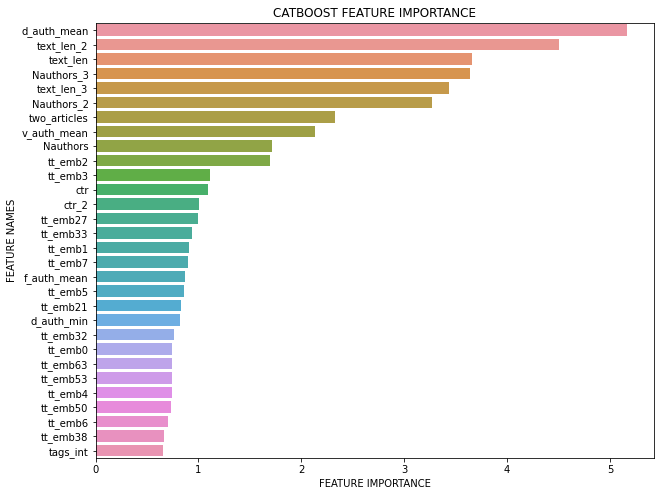

In [34]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(model_depth_start.get_feature_importance(), train_depth_start.get_feature_names(), 'CATBOOST')

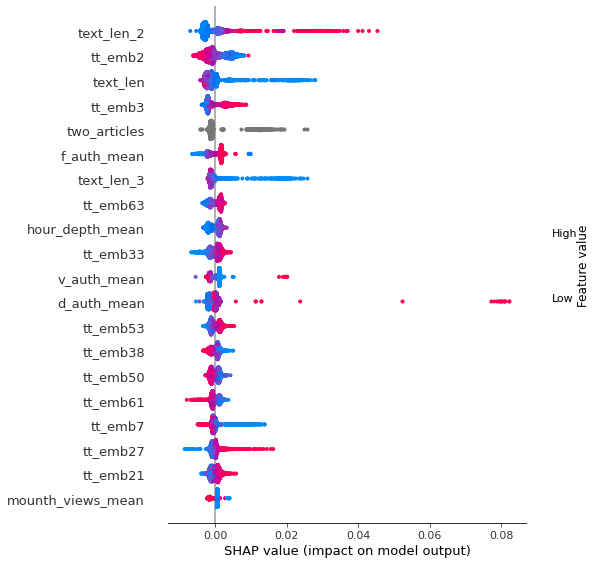

In [35]:
plot_feature_importance_shap(model_depth_start, df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])

In [36]:
cb_params_depth['iterations'] = 2500

In [37]:
%%time
model_depth_end = get_model(train_depth_end, cb_params_depth)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.3571611624
bestIteration = 2330

Training on fold [1/5]

bestTest = 0.2894635227
bestIteration = 2486

Training on fold [2/5]

bestTest = 0.3028484181
bestIteration = 2478

Training on fold [3/5]

bestTest = 0.009061872234
bestIteration = 1125

Training on fold [4/5]

bestTest = 0.3855100395
bestIteration = 2020

      iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
2478        2478      0.268084     0.150755       0.979855      0.003229        0.018052       0.003829         0.003047        0.000206
2478
Learning rate set to 0.024181
0:	learn: 0.0215916	total: 30.5ms	remaining: 1m 15s
100:	learn: 0.0179134	total: 2.98s	remaining: 1m 10s
200:	learn: 0.0154825	total: 5.91s	remaining: 1m 6s
300:	learn: 0.0139234	total: 8.88s	remaining: 1m 4s
400:	learn: 0.0128838	total: 11.9s	remaining: 1m 1s
500:	learn: 0.0120297	total: 14.8s	remaining: 58.6s
600:	learn: 0.0112692	tota

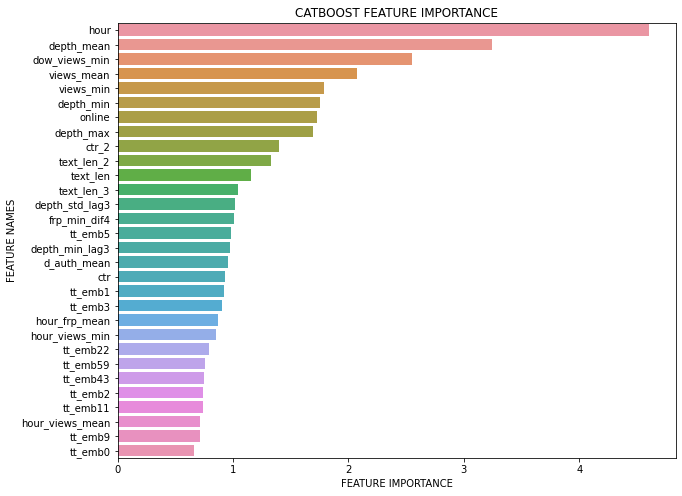

In [38]:
plot_feature_importance(model_depth_end.get_feature_importance(), train_depth_end.get_feature_names(), 'CATBOOST')

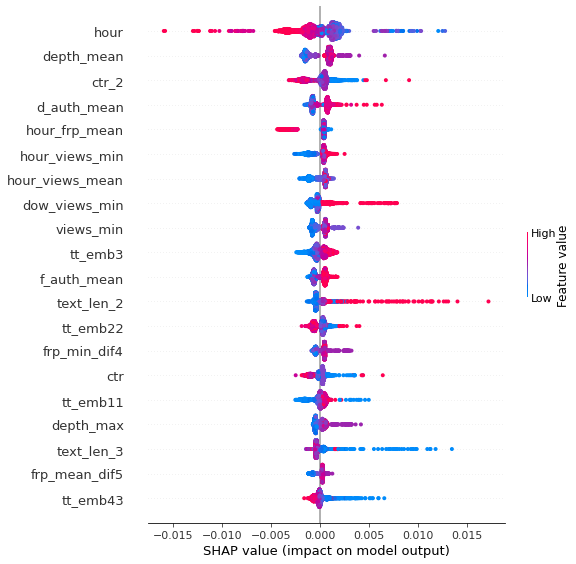

In [39]:
plot_feature_importance_shap(model_depth_end, df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])

## full_reads_percent

Обучаем модели для full_reads_percent с разделением на модели start (данные до 2022-04-08) / end (данные после 2022-04-08) 

In [40]:
cb_params_frp = cb_params_views

In [41]:
cb_params_frp['iterations'] = 1400

In [42]:
%%time
model_frp_start = get_model(train_frp_start, cb_params_frp)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5551328003
bestIteration = 1203

Training on fold [1/5]

bestTest = 0.5554389666
bestIteration = 1212

Training on fold [2/5]

bestTest = 0.5623900928
bestIteration = 1020

Training on fold [3/5]

bestTest = 0.5600288945
bestIteration = 1399

Training on fold [4/5]

bestTest = 0.5534101839
bestIteration = 1385

      iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
1212        1212      0.556957     0.003622       0.943576      0.001652        7.007425       0.149603         2.501923        0.036329
1212
Learning rate set to 0.042033
0:	learn: 10.3605632	total: 24.1ms	remaining: 29.2s
100:	learn: 6.7246914	total: 2.68s	remaining: 29.5s
200:	learn: 6.0934469	total: 5.37s	remaining: 27s
300:	learn: 5.3552147	total: 8.04s	remaining: 24.3s
400:	learn: 4.7118369	total: 10.7s	remaining: 21.7s
500:	learn: 4.1870183	total: 13.4s	remaining: 19s
600:	learn: 3.7275756	total: 16s	

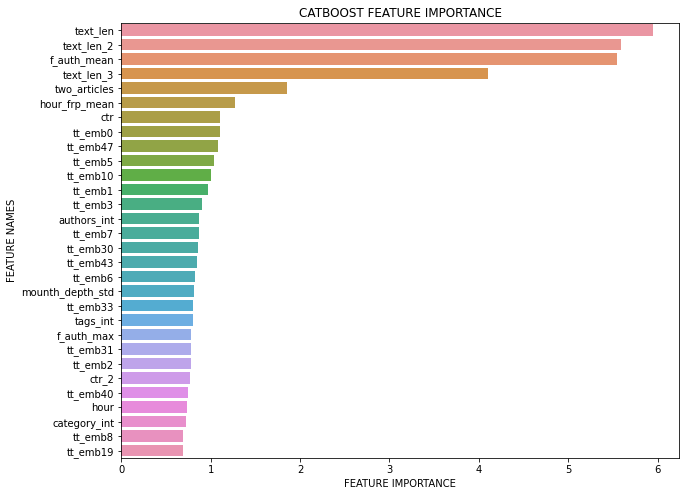

In [43]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(model_frp_start.get_feature_importance(), train_frp_start.get_feature_names(), 'CATBOOST')

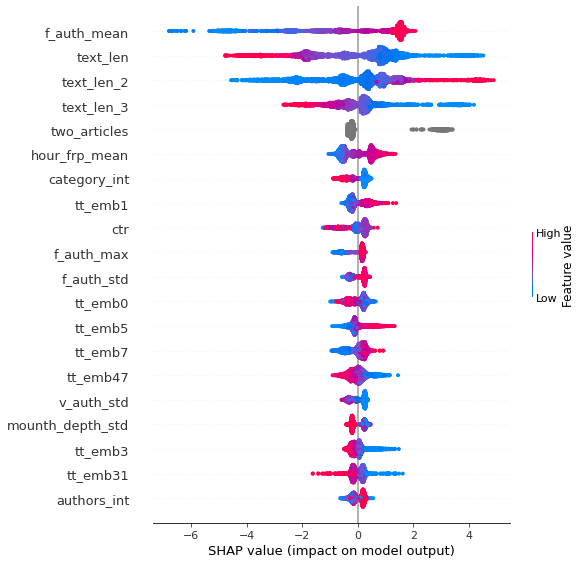

In [44]:
plot_feature_importance_shap(model_frp_start, df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])

In [45]:
cb_params_frp['iterations'] = 1000

In [46]:
%%time
model_frp_end = get_model(train_frp_end, cb_params_frp)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5664284199
bestIteration = 920

Training on fold [1/5]

bestTest = 0.5430209209
bestIteration = 995

Training on fold [2/5]

bestTest = 0.5066484092
bestIteration = 472

Training on fold [3/5]

bestTest = 0.5699809947
bestIteration = 999

Training on fold [4/5]

bestTest = 0.5603480137
bestIteration = 995

     iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
995         995      0.548247     0.027607        0.88739      0.004062        6.491644       0.070571         3.244837        0.048414
995
Learning rate set to 0.050774
0:	learn: 9.4729054	total: 34.2ms	remaining: 34s
100:	learn: 6.2071170	total: 3.21s	remaining: 28.4s
200:	learn: 5.5792953	total: 6.42s	remaining: 25.4s
300:	learn: 4.9293671	total: 9.66s	remaining: 22.3s
400:	learn: 4.4178906	total: 12.9s	remaining: 19.1s
500:	learn: 3.9957604	total: 16.1s	remaining: 15.9s
600:	learn: 3.5933674	total: 19.4s	remai

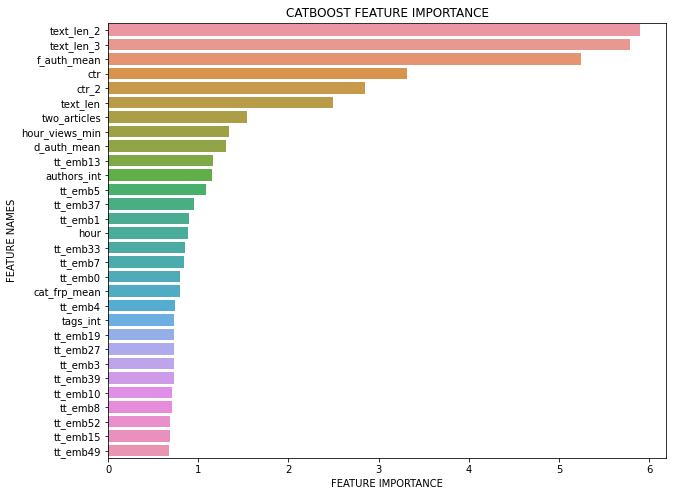

In [47]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(model_frp_end.get_feature_importance(), train_frp_end.get_feature_names(), 'CATBOOST')

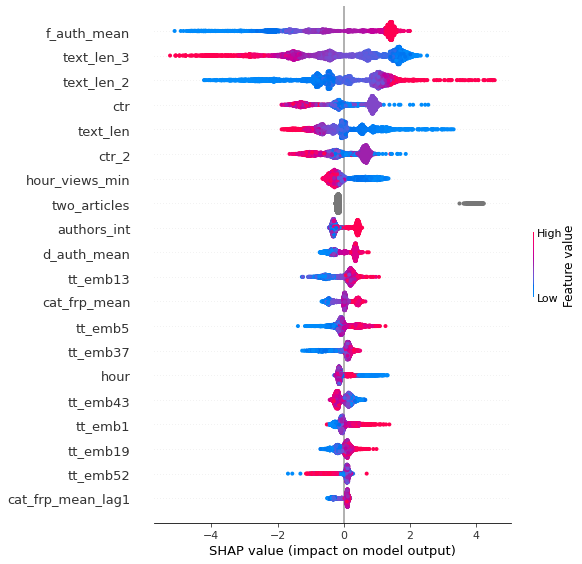

In [48]:
plot_feature_importance_shap(model_frp_end, df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])

## Сохраняем предсказания для ансамблей / стекинга

In [49]:
pred_train = pd.DataFrame()
pred_train[['document_id', 'distrib_brdr']] = df_train[['document_id', 'distrib_brdr']]
pred_train = pred_train.reindex(['document_id', 'distrib_brdr', 'views', 'depth', 'full_reads_percent'], axis = 1)

In [50]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'views'] = model_views_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'views'] = model_views_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
sum(pred_train.views.isna())

0

In [51]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'depth'] = model_depth_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'depth'] = model_depth_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
sum(pred_train.depth.isna())

0

In [52]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'full_reads_percent'] = model_frp_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'full_reads_percent'] = model_frp_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
sum(pred_train.full_reads_percent.isna())

0

## Сохраняем модели

In [53]:
#cb_model_views.save_model(os.path.join(DIR_MODELS, f'{NTRY}_pca64_cb_views.cbm'), 
model_views_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_v_start.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_views_end.save_model(os.path.join(DIR_MODELS, f'{NAME}_v_end.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_depth_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_d_start.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_depth_end.save_model(os.path.join(DIR_MODELS, f'{NAME}_d_end.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_frp_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_f_start.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_frp_end.save_model(os.path.join(DIR_MODELS, f'{NAME}_f_end.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

## Делаем предсказание / сабмит

In [54]:
subm = pd.DataFrame()
subm[['document_id', 'distrib_brdr']] = df_test[['document_id', 'distrib_brdr']]
subm = subm.reindex(['document_id', 'distrib_brdr', 'views', 'depth', 'full_reads_percent'], axis = 1)

In [55]:
subm.loc[subm.query('distrib_brdr == 1').index, 'views'] = model_views_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'views'] = model_views_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.views.isna())

0

In [56]:
subm.loc[subm.query('distrib_brdr == 1').index, 'depth'] = model_depth_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'depth'] = model_depth_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.depth.isna())

0

In [57]:
subm.loc[subm.query('distrib_brdr == 1').index, 'full_reads_percent'] = model_frp_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'full_reads_percent'] = model_frp_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.full_reads_percent.isna())

0

In [58]:
subm.drop(['distrib_brdr'], axis = 1, inplace = True)

In [59]:
doc_id_ukr = df_test[df_test.spec == 1].document_id.values
subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,196709.283259,1.187749,27.092151
1440,177978.671378,1.172821,25.179446
2645,197582.863715,1.187584,27.590232


In [60]:
# присваиваем статичные данные
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'views'] = VIEWS_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'depth'] = DEPTH_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'full_reads_percent'] = FPR_UKR

subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,2554204.0,1.799,4.978
1440,2554204.0,1.799,4.978
2645,2554204.0,1.799,4.978


In [61]:
subm.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,15554.012913,1.213264,46.136060
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,7219.558815,1.060882,33.894714
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,11998.766837,1.061686,31.151036
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,8685.853907,1.064444,38.441008
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,113349.203139,1.138324,26.843249


In [62]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NAME}.csv'), index = False)

In [63]:
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

Notebook Runtime: 32.43 Minutes
